In [9]:
import math

class Point:
    def __init__(self, x=0, y=0):
        self._x = x
        self._y = y

    def get_x(self):
        return self._x

    def set_x(self, x):
        self._x = x

    def get_y(self):
        return self._y

    def set_y(self, y):
        self._y = y

    def __eq__(self, other):
        if isinstance(other, Point):
            # Use math.isclose with a default relative tolerance of 1e-9 and an absolute tolerance of 0.0
            return math.isclose(self._x, other.get_x()) and math.isclose(self._y, other.get_y())
        return False

    def  __str__(self):
         return f'Point({self.get_x()}, {self.get_y()})'

    __repr__ = __str__

    def __hash__(self):
        return hash((self._x, self._y))

    def distance_to(self, other):
        return math.sqrt((self._x - other.get_x()) ** 2 + (self._y - other.get_y()) ** 2)

In [10]:
class Segment:
    def __init__(self, point1, point2):
        self._point1 = point1
        self._point2 = point2

    def  __str__(self):
         return f'Segment({self._point1}, {self._point2})'
        
    def _calculate_slope(self, p1, p2):
        if math.isclose(p1.get_x(), p2.get_x()):
            return float('inf')  # Vertical line
        return (p2.get_y() - p1.get_y()) / (p2.get_x() - p1.get_x())

    def _calculate_intercept(self, p, slope):
        if math.isinf(slope):  # Vertical line
            return p.get_x()
        return p.get_y() - slope * p.get_x()

    def is_parallel(self, other_segment):
        slope1 = self._calculate_slope(self._point1, self._point2)
        slope2 = self._calculate_slope(other_segment._point1, other_segment._point2)
        return math.isclose(slope1, slope2)

    def is_collinear(self, other_segment):
        if not self.is_parallel(other_segment):
            return False

        slope = self._calculate_slope(self._point1, self._point2)
        intercept1 = self._calculate_intercept(self._point1, slope)
        intercept2 = self._calculate_intercept(other_segment._point1, slope)
        return math.isclose(intercept1, intercept2)

    def is_point_on_segment(self, point):
        # Check if the point is within the x and y bounds of the segment
        x_min, x_max = sorted([self._point1.get_x(), self._point2.get_x()])
        y_min, y_max = sorted([self._point1.get_y(), self._point2.get_y()])
        within_x = x_min <= point.get_x() <= x_max
        within_y = y_min <= point.get_y() <= y_max

        # For vertical line, just check y bounds
        if math.isclose(self._point1.get_x(), self._point2.get_x()):
            return within_y

        # Calculate slope and intercept, then check if point satisfies line equation
        slope = self._calculate_slope(self._point1, self._point2)
        intercept = self._calculate_intercept(self._point1, slope)
        return within_x and within_y and math.isclose(point.get_y(), slope * point.get_x() + intercept)

    def get_intersection_point(self, other_segment):
        x1, y1 = self._point1.get_x(), self._point1.get_y()
        x2, y2 = self._point2.get_x(), self._point2.get_y()
        x3, y3 = other_segment._point1.get_x(), other_segment._point1.get_y()
        x4, y4 = other_segment._point2.get_x(), other_segment._point2.get_y()

        # For collinear case it is enough to check 3 points
        if self.is_collinear(other_segment):
            if self.is_point_on_segment(other_segment._point1):
                return other_segment._point1
            if self.is_point_on_segment(other_segment._point2):
                return other_segment._point2
            if other_segment.is_point_on_segment(self._point1):
                return self._point1
            return None
            
        # Calculate intersection point using line equations
        denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
        if denominator == 0:  # Lines are parallel
            return None
        
        px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denominator
        py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denominator

        # Check if intersection point lies within both segments
        if (min(x1, x2) <= px <= max(x1, x2) and
            min(y1, y2) <= py <= max(y1, y2) and
            min(x3, x4) <= px <= max(x3, x4) and
            min(y3, y4) <= py <= max(y3, y4)):
            return Point(px, py)
        
        return None

    '''
    Tries to position drones from both ends. Chooses positioning that covers more power stations
    Returns drone positions and number of covered Power Stations
    '''
    def position_drones(self, power_stations, radiusDroneBS, obstacles):
        # Check if the segment is obstructed by any obstacle
        if not obstacles.is_segment_clear(Segment(self._point1, self._point2)):
            return None, []
    
        # Calculate drone positions and covered stations starting from _point1
        drones_from_p1, covered_from_p1 = self._calculate_drone_positions(self._point1, self._point2, power_stations, radiusDroneBS, obstacles)
    
        # Calculate drone positions and covered stations starting from _point2
        drones_from_p2, covered_from_p2 = self._calculate_drone_positions(self._point2, self._point1, power_stations, radiusDroneBS, obstacles)
    
        # Determine which set of drone positions covers more power stations
        if covered_from_p1 >= covered_from_p2:
            return drones_from_p1, covered_from_p1
        else:
            return drones_from_p2, covered_from_p2
    
    def _calculate_drone_positions(self, start_point, end_point, power_stations, radiusDroneBS, obstacles):
        drones = []
        covered_power_stations = set()
    
        # Calculate direction vector from start to end point
        dx = end_point.get_x() - start_point.get_x()
        dy = end_point.get_y() - start_point.get_y()
        segment_length = math.sqrt(dx**2 + dy**2)
        direction = (dx / segment_length, dy / segment_length)
    
        # Position drones and count covered power stations
        distance = radiusDroneBS
        while distance < segment_length:
            # Calculate drone's position
            drone_x = start_point.get_x() + distance * direction[0]
            drone_y = start_point.get_y() + distance * direction[1]
            drone_position = Point(drone_x, drone_y)
            drones.append(drone_position)
    
            # Check each power station for coverage, considering obstacles
            for station in power_stations:
                station_segment = Segment(drone_position, station)
                if drone_position.distance_to(station) <= radiusDroneBS and obstacles.is_segment_clear(station_segment):
                    covered_power_stations.add(station)
    
            distance += radiusDroneBS
    
        return drones, covered_power_stations

In [105]:
class Triangle:
    def __init__(self, point1, point2, point3):
        self._point1 = point1
        self._point2 = point2
        self._point3 = point3
        self._segment1 = Segment(point1, point2)
        self._segment2 = Segment(point2, point3)
        self._segment3 = Segment(point1, point3)
        self._fermat_point = None

    def _sign(self, p1, p2, p3):
        return (p1.get_x() - p3.get_x()) * (p2.get_y() - p3.get_y()) - (p2.get_x() - p3.get_x()) * (p1.get_y() - p3.get_y())

    def is_point_inside(self, point):
        # Special case: all vertices are the same point
        if self._point1 == self._point2 and self._point2 == self._point3:
            return point == self._point1
        
        # Special case: triangle is a line (degenerate case)
        if self._segment1.is_collinear(self._segment2) and self._segment2.is_collinear(self._segment3):
            return self._segment1.is_point_on_segment(point) or self._segment2.is_point_on_segment(point) or self._segment3.is_point_on_segment(point)

        # Barycentric coordinate system
        d1 = self._sign(point, self._point1, self._point2)
        d2 = self._sign(point, self._point2, self._point3)
        d3 = self._sign(point, self._point3, self._point1)

        has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
        has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)

        # The point is on the inside if there are no signs differing (all non-negative or all non-positive)
        return not(has_neg and has_pos)

    def compute_fermat_point(self):
        if self._fermat_point is not None:
            return self._fermat_point

        # Special case: Collinear or two vertices are the same
        if self._point1 == self._point2 or self._point1 == self._point3 or self._point2 == self._point3 or \
           self._segment1.is_collinear(self._segment2) or self._segment2.is_collinear(self._segment3) or self._segment1.is_collinear(self._segment3):
            # Find the vertex that lies between the other two vertices
            if self._segment1.is_point_on_segment(self._point3):
                self._fermat_point = self._point3
            elif self._segment2.is_point_on_segment(self._point1):
                self._fermat_point = self._point1
            else:
                self._fermat_point = self._point2
            return self._fermat_point
        # Check if any angle is 120 degrees or more
        if self._angle_is_large(self._point1, self._point2, self._point3) or \
           self._angle_is_large(self._point2, self._point3, self._point1) or \
           self._angle_is_large(self._point3, self._point1, self._point2):
            # The Fermat point is at the vertex with the large angle
            # Determine which vertex it is and set it as the Fermat point
            for p in [self._point1, self._point2, self._point3]:
                if self._angle_is_large(p, *[point for point in [self._point1, self._point2, self._point3] if point != p]):
                    self._fermat_point = p
                    return self._fermat_point

        # For triangles with all angles less than 120 degrees, construct equilateral triangles and find their intersections
        fp3 = self._construct_equilateral(self._point1, self._point2)
        fp1 = self._construct_equilateral(self._point2, self._point3)
        print(fp3, self._point1, self._point2)
        print(fp1, self._point2, self._point3)
        # Find intersection of lines (point1, fp1) and (point3, fp3)
        self._fermat_point = self._find_intersection(self._point3, fp3, self._point1, fp1)
        return self._fermat_point

    def _angle_is_large(self, p1, p2, p3):
        # Use the law of cosines to calculate the angle at p1 formed by p2 and p3
        a = math.dist([p2.get_x(), p2.get_y()], [p3.get_x(), p3.get_y()])
        b = math.dist([p1.get_x(), p1.get_y()], [p3.get_x(), p3.get_y()])
        c = math.dist([p1.get_x(), p1.get_y()], [p2.get_x(), p2.get_y()])
        # Ensure the value inside acos is within the range [-1, 1]
        cos_angle = max(min((b**2 + c**2 - a**2) / (2 * b * c), 1), -1)
        angle = math.acos(cos_angle)
        return angle >= (2 * math.pi / 3)  # Check if the angle is 120 degrees or more in radians

    def _construct_equilateral(self, p1, p2):
        # Calculate the midpoint of the line segment
        mx, my = (p1._x + p2._x) / 2, (p1._y + p2._y) / 2
    
        # Calculate the slope of the perpendicular bisector
        if math.isclose(p2._x, p1._x):  # Handle vertical line case
            dx, dy = 0, 1  # Perpendicular to vertical is horizontal
        else:
            slope = (p2._y - p1._y) / (p2._x - p1._x)
            dx, dy = -slope, 1  # Perpendicular slope
    
        # Normalize the direction vector (dx, dy)
        length = math.hypot(dx, dy)
        dx, dy = dx / length, dy / length
    
        # Calculate the length of the side of the equilateral triangle
        side_length = p1.distance_to(p2)
    
        # The height of the equilateral triangle
        height = math.sqrt(3) / 2 * side_length
    
        # Determine the direction to construct the third point
        # For a horizontal line segment, we always go upwards
        direction = 1
    
        # Determine the third point of the equilateral triangle
        ex = mx + direction * dx * height
        ey = my + direction * dy * height
    
        return Point(ex, ey)

    def _find_intersection(self, p1, q1, p2, q2):
        # Line p1q1 represented as a1x + b1y = c1
        a1 = q1._y - p1._y
        b1 = p1._x - q1._x
        c1 = a1 * p1._x + b1 * p1._y

        # Line p2q2 represented as a2x + b2y = c2
        a2 = q2._y - p2._y
        b2 = p2._x - q2._x
        c2 = a2 * p2._x + b2 * p2._y

        determinant = a1 * b2 - a2 * b1

        if math.isclose(determinant, 0):
            return None  # The lines are parallel

        # Intersection point
        x = (c1 * b2 - c2 * b1) / determinant
        y = (a1 * c2 - a2 * c1) / determinant
        return Point(x, y)

    '''
    Tries to position drones from all 3 ends through Fermat-Torricelli point. Chooses positioning that uses less drones
    or, in case of equality, covers more power stations
    Also tries to position drones starting from Fermat point and chooses this option if it is the best
    Returns drone positions and number of covered Power Stations
    '''
    def position_drones(self, power_stations, radiusDroneBS, obstacles):
        fermat_point = self.compute_fermat_point()
        print(fermat_point)
        best_drones = []
        best_covered_stations = set()  # Use a set to store unique covered stations

        # First solution: Try positioning drones from each vertex
        for vertex in [self._point1, self._point2, self._point3]:
            drones, covered_stations = self._position_drones_from_vertex(vertex, fermat_point, power_stations, radiusDroneBS, obstacles)
            if len(drones) < len(best_drones) or (len(drones) == len(best_drones) and len(covered_stations) > len(best_covered_stations)):
                best_drones = drones
                best_covered_stations = covered_stations

        # Second solution: Start with a drone at the Fermat point and extend towards each vertex
        fermat_drones = [fermat_point]
        fermat_covered_stations = set()
        for station in power_stations:
            if fermat_point.distance_to(station) <= radiusDroneBS:
                fermat_covered_stations.add(station)
        
        for vertex in [self._point1, self._point2, self._point3]:
            additional_drones, covered_stations = Segment(fermat_point, vertex)._calculate_drone_positions(fermat_point, vertex, power_stations, radiusDroneBS, obstacles)
            fermat_drones.extend(additional_drones)
            fermat_covered_stations.update(covered_stations)

        # Compare and pick the best solution
        if len(fermat_drones) < len(best_drones) or (len(fermat_drones) == len(best_drones) and len(fermat_covered_stations) > len(best_covered_stations)):
            return fermat_drones, len(fermat_covered_stations)
        else:
            return best_drones, len(best_covered_stations)

    def _position_drones_from_vertex(self, start_vertex, fermat_point, power_stations, radiusDroneBS, obstacles):
        drones = []
        covered_power_stations = set()

        # Position drones from start_vertex to Fermat point using _calculate_drone_positions from Segment class
        segment_to_fermat = Segment(start_vertex, fermat_point)
        drones_to_fermat, covered_stations = segment_to_fermat._calculate_drone_positions(start_vertex, fermat_point, power_stations, radiusDroneBS, obstacles)
        drones.extend(drones_to_fermat)
        covered_power_stations.update(covered_stations)

        last_drone_position = drones[-1] if drones else start_vertex

        # For each of the other vertices, use binary search to find the optimal next drone position
        for next_vertex in [self._point1, self._point2, self._point3]:
            if next_vertex == start_vertex:
                continue

            next_drone_position = self._binary_search_next_position(last_drone_position, fermat_point, next_vertex, radiusDroneBS, obstacles)
            if next_drone_position:
                drones.append(next_drone_position)
                # Continue positioning drones from this new point to the vertex
                next_segment = Segment(next_drone_position, next_vertex)
                additional_drones, covered_stations = next_segment._calculate_drone_positions(next_drone_position, next_vertex, power_stations, radiusDroneBS, obstacles)
                drones.extend(additional_drones)
                covered_power_stations.update(covered_stations)

        return drones, covered_power_stations

    def _binary_search_next_position(self, last_position, fermat_point, vertex, radiusDroneBS, obstacles):
        # Calculate point P on the segment from fermat_point towards the vertex at a distance of radiusDroneBS
        direction = self._calculate_direction(fermat_point, vertex)
        P_x = fermat_point.get_x() + direction[0] * radiusDroneBS
        P_y = fermat_point.get_y() + direction[1] * radiusDroneBS
        P = Point(P_x, P_y)
    
        # Initialize binary search bounds
        low, high = 0, 1  # Low at fermat_point, high at P
    
        # Perform binary search to find the optimal point M on the segment from fermat_point to P
        while (high - low) > 1e-5:  # Continue until the interval is sufficiently small
            mid = (low + high) / 2  # Calculate the midpoint of the current range
            # Calculate the coordinates of the midpoint M on the segment
            M_x = fermat_point.get_x() + (P_x - fermat_point.get_x()) * mid
            M_y = fermat_point.get_y() + (P_y - fermat_point.get_y()) * mid
            M = Point(M_x, M_y)  # Create a Point object for the midpoint
    
            # Check if the segment from the last position to M is clear and within the drone radius
            if last_position.distance_to(M) <= radiusDroneBS and obstacles.is_segment_clear(Segment(last_position, M)):
                low = mid  # Move the lower bound up to search further towards P
            else:
                high = mid  # Move the upper bound down to shorten the segment towards fermat_point
    
        # Calculate the final point M using the last low value
        M_x = fermat_point.get_x() + (P_x - fermat_point.get_x()) * low
        M_y = fermat_point.get_y() + (P_y - fermat_point.get_y()) * low
        final_M = Point(M_x, M_y)
    
        # Check if final_M is valid (clear and within the drone radius)
        if last_position.distance_to(final_M) <= radiusDroneBS and obstacles.is_segment_clear(Segment(last_position, final_M)):
            return final_M
        else:
            return None
    
    def _calculate_direction(self, start, end):
        dx = end.get_x() - start.get_x()
        dy = end.get_y() - start.get_y()
        length = math.sqrt(dx**2 + dy**2)
        return dx / length, dy / length

In [106]:
class Obstacles:
    def __init__(self):
        self.triangles = []

    def add_triangle(self, triangle):
        self.triangles.append(triangle)

    def is_point_inside_any_obstacle(self, point):
        for triangle in self.triangles:
            if triangle.is_point_inside(point):
                return True  # The point is inside at least one triangle
        return False  # The point is not inside any triangle

    def __str__(self):
        return '\n'.join(str(triangle) for triangle in self.triangles)

    #checks if ends of segment have LOS connection
    def is_segment_clear(self, segment):
        for triangle in self.triangles:
            # Check if any endpoint of the segment is inside a triangle
            if triangle.is_point_inside(segment._point1) or triangle.is_point_inside(segment._point2):
                return False
            
            # Check for intersection between the segment and each side of the triangle
            for tri_segment in [Segment(triangle._point1, triangle._point2),
                                Segment(triangle._point2, triangle._point3),
                                Segment(triangle._point3, triangle._point1)]:
                if segment.get_intersection_point(tri_segment) is not None:
                    return False  # The segment intersects with a triangle side

        return True  # The segment is clear of all obstacles

In [107]:
class ConnectivityComponent:
    def __init__(self):
        self.BSs = []
    def addBS(self, newBS):
        self.BSs.append(newBS)
    def __str__(self):
        # Generate a list of string representations of Point objects and join them with ', '
        bs_strings = [str(bs) for bs in self.BSs]
        component_str = "Connectivity Component: [" + ', '.join(bs_strings) + "]"
        return component_str
    __repr__ = __str__

# Responsible for initializing graph
class GraphBuilder:
    def __init__(self, radiusBS, radiusDroneBS, baseStations, power_stations=[], obstacles=[]):
        # Filter out base and power stations that are inside obstacles
        baseStations, power_stations = self._check_stations_over_obstacles(baseStations, power_stations, obstacles)

        # Find initial connectivity components in graph
        self._components = self._find_components(baseStations, radiusBS, obstacles)

        # Filter out power stations covered by functioning ground BS
        self._power_stations = self._filter_covered_power_stations(power_stations, baseStations, radiusBS, obstacles)
        
        self._obstacles = obstacles
        self._radiusBS = radiusBS
        self._radiusDroneBS = radiusDroneBS

        print(self._components)

    def _check_stations_over_obstacles(self, baseStations, power_stations, obstacles):
        filtered_base_stations = []
        filtered_power_stations = []

        # Check base stations
        for base in baseStations:
            if not obstacles.is_point_inside_any_obstacle(base):
                filtered_base_stations.append(base)
            else:
                print(f"Base station at {base} is within an obstacle and will be filtered out.")

        # Check power stations
        for power in power_stations:
            if not obstacles.is_point_inside_any_obstacle(power):
                filtered_power_stations.append(power)
            else:
                print(f"Power station at {power} is within an obstacle and will be filtered out.")

        return filtered_base_stations, filtered_power_stations
    
    def _filter_covered_power_stations(self, power_stations, baseStations, radiusBS, obstacles):
        filtered_power_stations = []
        for power in power_stations:
            is_close_to_base_station = False
            for base in baseStations:
                if power.distance_to(base) <= radiusBS:
                    # Check if the segment between power and base is clear of obstacles
                    segment = Segment(power, base)
                    if obstacles.is_segment_clear(segment):
                        is_close_to_base_station = True
                        print(f"Power station at {power} is initially covered by {base}.")
                        break  # No need to check further if one is found within radiusBS and clear of obstacles
            if not is_close_to_base_station:
                filtered_power_stations.append(power)
        return filtered_power_stations

    def _find_components(self, baseStations, radiusBS, obstacles):
        def dfs(node, visited, component):
            visited[node] = True
            component.addBS(baseStations[node])
            for neighbor in graph[node]:
                if not visited[neighbor]:
                    dfs(neighbor, visited, component)

        # Create the graph
        graph = {i: [] for i in range(len(baseStations))}
        for i, base1 in enumerate(baseStations):
            for j, base2 in enumerate(baseStations):
                if i != j and base1.distance_to(base2) <= radiusBS:
                    # Check if the segment between base1 and base2 is clear of obstacles
                    segment = Segment(base1, base2)
                    if obstacles.is_segment_clear(segment):
                        graph[i].append(j)

        # Find connected components using DFS
        visited = [False] * len(baseStations)
        components = []
        for i in range(len(baseStations)):
            if not visited[i]:
                component = ConnectivityComponent()
                dfs(i, visited, component)
                components.append(component)

        return components

In [108]:
class Solver:
    def __init__(graphBuilder):
         # Find initial connectivity components in graph
        self._components = graphBuilder._components
        self._power_stations = graphBuilder._power_stations
        self._obstacles = graphBuilder._obstacles
        self._radiusBS = graphBuilder._radiusBS
        self._radiusDroneBS = graphBuilder._radiusDroneBS


In [110]:
'''
radiusBS = 5    
radiusDroneBS = 3
baseStations = [Point(1, 1), Point(1, 0), Point(6, 0), Point(-10, 5), Point(-10, 6), Point(100, 100)]
power_stations = [Point(0, 0), Point(200, 200)]
obstacles = Obstacles()
obstacles.add_triangle(Triangle(Point(2, 0), Point(3, 0), Point(2.5, 10)))
graphBuilder = GraphBuilder(radiusBS, radiusDroneBS, baseStations, power_stations, obstacles)
'''
power_stations = [Point(1.9, 3)]
radiusDroneBS = 2
segment = Segment(Point(0, 0), Point(0, 9))
print(segment.position_drones(power_stations, radiusDroneBS, Obstacles()))

t = Triangle(Point(100, 0), Point(0, 0), Point(0, 100))

power_stations = [Point(20, 20)]
obstacles = Obstacles()
#print(t.position_drones(power_stations, radiusDroneBS, obstacles))
print(t.compute_fermat_point())

([Point(0.0, 7.0), Point(0.0, 5.0), Point(0.0, 3.0), Point(0.0, 1.0)], {Point(1.9, 3)})
Point(50.0, 86.60254037844386) Point(100, 0) Point(0, 0)
Point(0.0, 136.60254037844385) Point(0, 0) Point(0, 100)
Point(33.33333333333333, 91.0683602522959)


In [48]:
# And implement the algorithm from the Lavesh's thesis

In [18]:
# I also have to implement metaheuristic to find a proper path

In [4]:
import csv
import json

# Define the input CSV file path
csv_file_path = 'rural_mv_2.csv'
json_file_path = 'rural_mv_2.json'

# Initialize a dictionary to store the base stations
data = {"base_stations": []}

# Read the CSV file
with open(csv_file_path, mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file, delimiter=';')
    for row in csv_reader:
        # Extract x and y and append them as a list to base_stations
        data["base_stations"].append([float(row['x']), float(row['y'])])

# Write the data to a JSON file
with open(json_file_path, mode='w') as json_file:
    json.dump(data, json_file, indent=2)

print(f"Data has been written to {json_file_path}")

Data has been written to rural_mv_2.json


In [12]:
import json
import math

# Define the input JSON file path
json_file_path = 'rural_mv_2.json'
output_json_file_path = '1rural_mv_2.json'

# Read the JSON file
with open(json_file_path, mode='r') as json_file:
    data = json.load(json_file)

# Extract base stations
base_stations = data["base_stations"]

# Initialize minimum values with the first base station coordinates
min_x = base_stations[0][0]
min_y = base_stations[0][1]

# Find the minimum x and y values
for station in base_stations:
    x, y = station
    if x < min_x:
        min_x = x
    if y < min_y:
        min_y = y

# Subtract the minimum values from all x and y values and convert to kilometers
for i in range(len(base_stations)):
    base_stations[i][0] = (base_stations[i][0] - min_x) * 111  # Convert latitude to kilometers
    base_stations[i][1] = (base_stations[i][1] - min_y) * 111 * math.cos(math.radians(base_stations[i][0]))  # Convert longitude to kilometers

# Write the adjusted data to a new JSON file
with open(output_json_file_path, mode='w') as json_file:
    json.dump(data, json_file, indent=2)

print(f"Adjusted data has been written to {output_json_file_path}")

Adjusted data has been written to 1rural_mv_2.json


In [16]:
# Define the input JSON file path
json_file_path = '1rural_mv_2.json'
output_json_file_path = '2rural_mv_2.json'

# Read the JSON file
with open(json_file_path, mode='r') as json_file:
    data = json.load(json_file)

# Extract base stations
base_stations = data["base_stations"]

# Initialize minimum values with the first base station coordinates
min_x = base_stations[0][0]
min_y = base_stations[0][1]

# Find the minimum x and y values
for station in base_stations:
    x, y = station
    if x < min_x:
        min_x = x
    if y < min_y:
        min_y = y

# Subtract the minimum values from all x and y values
for i in range(len(base_stations)):
    base_stations[i][0] -= min_x
    base_stations[i][1] -= min_y

# Write the adjusted data to a new JSON file
with open(output_json_file_path, mode='w') as json_file:
    json.dump(data, json_file, indent=2)

print(f"Adjusted data has been written to {output_json_file_path}")

Adjusted data has been written to 2rural_mv_2.json


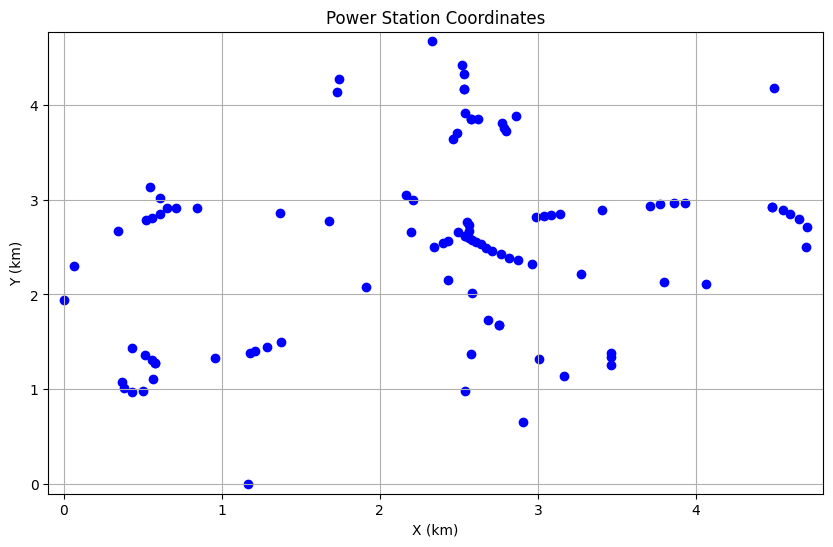

In [8]:
import json
import matplotlib.pyplot as plt

# Read JSON data from the file
with open('rural_mv_0.json', 'r') as file:
    data = json.load(file)

# Extract base station coordinates
power_stations = data['power_stations']

# Split the coordinates into two lists: x and y
x_coords = [station[0] for station in power_stations]
y_coords = [station[1] for station in power_stations]

# Plot the coordinates
plt.figure(figsize=(10, 6))
plt.scatter(x_coords, y_coords, color='blue', marker='o')
plt.title('Power Station Coordinates')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')

# Set scale depending on the data range
plt.xlim(min(x_coords) - 0.1, max(x_coords) + 0.1)
plt.ylim(min(y_coords) - 0.1, max(y_coords) + 0.1)

# Show the plot
plt.grid(True)
plt.show()

In [6]:
print(power_stations)

[[2.541899999999991, 2.6170224600187315], [2.541899999999991, 2.6170224600187315], [2.5641000000001366, 2.6724216816581547], [2.5641000000001366, 2.7278661148878482], [2.5530000000001625, 2.761156677670392], [2.7971999999999877, 3.7251562688683695], [2.7861000000000136, 3.7584520976965585], [2.7750000000000394, 3.802835396284596], [2.6196000000000073, 3.847674947939093], [2.5752000000001107, 3.847810211314609], [2.541899999999991, 3.9144446118084906], [2.8638000000000297, 3.8801481125853754], [2.464199999999975, 3.6374332836829284], [2.4864000000001205, 3.703909657680828], [2.4309000000000527, 2.5617925689211933], [2.3976000000001303, 2.5396747783045233], [2.3421000000000625, 2.4954136814008754], [1.9092000000000855, 2.074547736005706], [1.3764000000001442, 1.4980676355989078], [1.287600000000154, 1.4426356366140842], [1.2099000000001379, 1.409385707328053], [1.1766000000000183, 1.3872074499626306], [0.9546000000001413, 1.3318151319849827], [2.586300000000085, 2.018142200001638], [2.68